<a href="https://colab.research.google.com/github/Solo7602/MADPA/blob/main/Mosh1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


Comment_processed...
Comment_processed! Ready!


Some weights of the model checkpoint at DeepPavlov/rubert-base-cased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
BERT embedding: 100%|██████████| 37785/37785 [1:14:53<00:00,  8.41it/s]


              precision    recall  f1-score   support

           0       0.69      0.89      0.78      4519
           1       0.48      0.30      0.37      2097
           2       0.51      0.23      0.31       941

    accuracy                           0.64      7557
   macro avg       0.56      0.47      0.49      7557
weighted avg       0.61      0.64      0.61      7557


Метрики качества:
Accuracy: 0.6430
Precision (weighted): 0.6092
Recall (weighted): 0.6430
F1-score (weighted): 0.6066

Кросс-валидация с различными метриками:
Accuracy: 0.6441 ± 0.0016
Precision: 0.6121 ± 0.0022
Recall: 0.6441 ± 0.0016
F1-score: 0.4925 ± 0.0024


<Figure size 1000x700 with 0 Axes>

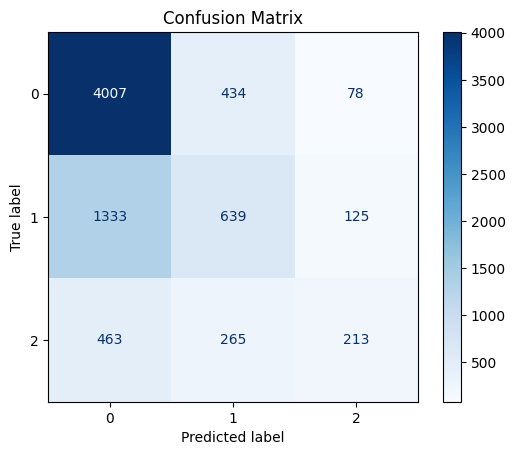

In [17]:
import os
os.environ["TRANSFORMERS_NO_TF"] = "1"  # избегаем конфликта с TensorFlow

import pandas as pd
import json
import numpy as np
import re
import torch
from transformers import AutoTokenizer, AutoModel
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
from tqdm import tqdm
import xgboost as xgb
from sklearn.model_selection import cross_val_score, StratifiedKFold
from pymorphy3 import MorphAnalyzer
from razdel import tokenize
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from spellchecker import SpellChecker
from tqdm import tqdm

nltk.download('stopwords')
nltk.download('punkt_tab')

# Инициализация проверяющего (русский язык)
spell_ru = SpellChecker(language='ru')

nltk.download('stopwords')
nltk.download('punkt_tab')


# Загрузка сленгового словаря
with open('russian_slang_words.json', 'r', encoding='utf-8') as f:
    slang_words = set(json.load(f))

# Загружаем данные
data = pd.read_csv('10k_dataset_processed_final.csv').head(40000)
data['Comment'] = data['Comment'].fillna("")

morph = MorphAnalyzer()

patterns = "[0-9!#$%&'()*+,./:;<=>?@[\]^_`{|}~—\"\-]+"

russian_stopwords = stopwords.words('russian')
english_stopwords = stopwords.words('english')

def is_english_word(word):
    return bool(re.fullmatch(r"[a-z]+(?:'[a-z]+)*", word))

def is_russian_word(word):
    return all(
        ('\u0400' <= c <= '\u04FF') or c in ['ё', 'Ё']
        for c in word
    )

def preprocess_text(text):
    text = re.sub(patterns, ' ', text)
    text = text.lower()
    words = word_tokenize(text)

    normalized_words = []
    for word in words:
        if word in russian_stopwords or word in english_stopwords or len(word) <= 2:
            continue
        if word.isalpha():
            if any('\u0400' <= char <= '\u04FF' for char in word):
                normalized_words.append(morph.parse(word)[0].normal_form)
            else:
                normalized_words.append(word)

    return ' '.join(normalized_words)

def preprocess_text(text):
    text = re.sub(patterns, ' ', text)
    text = text.lower()
    words = word_tokenize(text)

    normalized_words = []
    for word in words:
        if word in russian_stopwords or word in english_stopwords or len(word) <= 2:
            continue
        if is_english_word(word):
            normalized_words.append(word)
        elif is_russian_word(word):
            lemma = morph.parse(word)[0].normal_form
            normalized_words.append(lemma)
        else:
            continue

    return ' '.join(normalized_words)

def preprocess_text_tokens(text):
    text = re.sub(patterns, ' ', text)
    text = text.lower()
    words = word_tokenize(text)

    normalized_words = []
    for word in words:
        if len(word) <= 2:
            continue
        if word in russian_stopwords or word in english_stopwords:
            continue

        if is_english_word(word):
            normalized_words.append(word)
        elif is_russian_word(word):
            lemma = morph.parse(word)[0].normal_form
            normalized_words.append(lemma)
        else:
            continue

    return normalized_words

def analyze_comment(text):
        tokens = preprocess_text_tokens(text)

        misspelled = spell_ru.unknown(tokens)
        num_errors = len(misspelled)
        has_errors = num_errors > 0

        # Проверка на наличие сленга
        slang_found = [word for word in tokens if word in slang_words]
        num_slang = len(slang_found)
        has_slang = num_slang > 0

        return pd.Series([num_errors, has_errors, num_slang, has_slang])

print('Comment_processed...')
data['Comment_processed'] = data['Comment'].apply(preprocess_text)
data['Comment_processed'] = data['Comment_processed'].fillna("")
print('Comment_processed! Ready!')
data = data.replace("", pd.NA)
data = data.dropna()

# Применение анализа к каждому комментарию
data[['Spell_Errors', 'Has_Spell_Errors', 'Slang_Count', 'Has_Slang']] = data['Comment'].apply(analyze_comment)

# # Создание возрастных групп
bins = [0, 30, 45, 100]
labels = [0, 1, 2]
data['Age_Group'] = pd.cut(data['Age'], bins=bins, labels=labels).astype(int)

# # Числовые признаки
def count_punctuation(text):
    return len(re.findall(r"[.,!?;:\-–—]", text))

def ends_with_punctuation(text):
    text = text.strip()
    return int(text[-1] in {'.', ',', '!', '?'}) if text else 0

data['Emoji_Count'] = data['Comment'].apply(lambda x: len(re.findall(r'[\U0001F600-\U0001F64F]', x)))
data['Punctuation_Count'] = data['Comment'].apply(count_punctuation)
data['Word_Count'] = data['Comment'].apply(lambda x: len(x.split()))
data['Avg_Word_Length'] = data['Comment'].apply(lambda x: np.mean([len(w) for w in x.split()]) if x.split() else 0)
data['Ends_With_Punct'] = data['Comment'].apply(ends_with_punctuation)
data['Comment_Length'] = data['Comment'].apply(len)

# # Сохраните обновленный DataFrame в файле
# data.to_csv('40000_dataset_processed.csv', index=False)


numeric_features = ['Emoji_Count', 'Punctuation_Count', 'Word_Count', 'Avg_Word_Length', 'Ends_With_Punct', 'Comment_Length']
scaler = StandardScaler()
scaled_features = scaler.fit_transform(data[numeric_features])

# BERT эмбеддинги
model_name = "DeepPavlov/rubert-base-cased"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name)
model.eval()

def get_bert_embedding(text):
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=128)
    with torch.no_grad():
        outputs = model(**inputs)
    return outputs.last_hidden_state[:, 0, :].squeeze().numpy()

bert_embeddings = []
for comment in tqdm(data['Comment'], desc="BERT embedding"):
    try:
        emb = get_bert_embedding(comment)
    except Exception:
        emb = np.zeros(768)
    bert_embeddings.append(emb)

bert_features = np.vstack(bert_embeddings)

# Объединение признаков
X = np.hstack([bert_features, scaled_features])

y = data['Age_Group'].values

# Разделение данных
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Обучение XGBoost
xgb_clf = xgb.XGBClassifier(
    objective="multi:softmax",
    num_class=3,
    max_depth=6,
    learning_rate=0.1,
    n_estimators=1000,
    eval_metric="mlogloss",
    random_state=42
)

xgb_clf.fit(X_train, y_train)

# Предсказание и оценка
y_pred = xgb_clf.predict(X_test)
print(classification_report(y_test, y_pred))


# # Подбор гиперпараметров с помощью GridSearchCV
# from sklearn.model_selection import GridSearchCV

# param_grid = {
#     'max_depth': [3, 6, 9],
#     'learning_rate': [0.01, 0.1, 0.2],
#     'n_estimators': [100, 200, 300],
# }

# grid_search = GridSearchCV(xgb_clf, param_grid, scoring='f1_macro', cv=cv)
# grid_search.fit(X_train, y_train)

# print(f'Лучшие гиперпараметры: {grid_search.best_params_}')
# print(f'Лучший F1-score: {grid_search.best_score_:.4f}')

# Анализ ошибок
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# После предсказания и вывода classification_report добавим более детальную оценку

from sklearn.metrics import precision_recall_fscore_support, accuracy_score
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Вычисление дополнительных метрик
precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred, average='weighted')
accuracy = accuracy_score(y_test, y_pred)

cv = StratifiedKFold(n_splits=4, shuffle=True, random_state=42)

print('\nМетрики качества:')
print(f'Accuracy: {accuracy:.4f}')
print(f'Precision (weighted): {precision:.4f}')
print(f'Recall (weighted): {recall:.4f}')
print(f'F1-score (weighted): {f1:.4f}')

# Кросс-валидация с дополнительными метриками
print('\nКросс-валидация с различными метриками:')
cv_accuracy = cross_val_score(xgb_clf, X, y, cv=cv, scoring='accuracy')
cv_precision = cross_val_score(xgb_clf, X, y, cv=cv, scoring='precision_weighted')
cv_recall = cross_val_score(xgb_clf, X, y, cv=cv, scoring='recall_weighted')
cv_scores = cross_val_score(xgb_clf, X, y, cv=cv, scoring='f1_macro')

print(f'Accuracy: {cv_accuracy.mean():.4f} ± {cv_accuracy.std():.4f}')
print(f'Precision: {cv_precision.mean():.4f} ± {cv_precision.std():.4f}')
print(f'Recall: {cv_recall.mean():.4f} ± {cv_recall.std():.4f}')
print(f'F1-score: {cv_scores.mean():.4f} ± {cv_scores.std():.4f}')

# Вывод матрицы ошибок
plt.figure(figsize=(10, 7))
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues', values_format='d')
plt.title('Confusion Matrix')
plt.show()